<a href="https://colab.research.google.com/github/VincentK1991/Authorship_attribution/blob/master/Machine_Learning_Guide_to_Authorship_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Introduction

we're going to explore NLP problem of authorship attribution. The task is to identify who the author is from the text. We are going to treat this as a text classification problem, where we train a classification model on a training set (i.e. the set of texts you know for sure who wrote them), then apply the model on a set where you don't know.

We will use a dataset from this [kaggle](https://www.kaggle.com/c/spooky-author-identification). The dataset contains texts from books written by one of the 3 horror writers, H.P. Lovecraft, Edgar Allen Poe, or Mary Shelley. So our task is to classify who wrote which text. A nice thing about this dataset is that besides it being multi-class classification is that since all three of them write in horror genre, the content may be relatively of the same moods and tones. So one might say, it's harder to differentiate, than let's say a horror writer from a romance writer.

We will explore 4 ML approaches

1. TF-IDF and regularized regression

2. Naive Bayes classifier

3. recurrent neural network

4. BERT classification

# 1. Data exploration

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_df = pd.read_csv('spooky-author-identification/train.csv')

One thing we need to check is whether the classes are balanced. Training on imbalanced data can lead to model bias. So we will do sub-sampling so each class has equal data.

In [0]:
train_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [0]:
g = train_df.groupby('author')
train_resampled = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [0]:
train_resampled.author.value_counts()

MWS    5635
HPL    5635
EAP    5635
Name: author, dtype: int64

We will change the author label to numeric

In [0]:
train_resampled['author'] = np.where(train_resampled['author'] == 'EAP',0,
                                     np.where(train_resampled['author'] == 'HPL',1,2))

In [0]:
train_resampled.tail()

id                                               text  author
author                                                                         
MWS    5630  id11811  Unable to endure the aspect of the being I had...       2
       5631  id12409  I thought with a sensation of madness on my pr...       2
       5632  id10423  But if his countenance was more sorrowful, his...       2
       5633  id27947               Adrian was now fifteen years of age.       2
       5634  id14473  My thoughts were sad and solemn, yet not of un...       2

# 2. TFIDF-regression


The first approach we will consider is a more traditional ML model, namely, TF-IDF and regression. I have written elsewhere about how TF-IDF works. But to explain briefly, TFIDF weigh the frequency of words in the corpus against number of documents in the corpus that contain the word. That idea being words that appear often equally across documents are not useful for the purpose of identification. Words that are useful for identification are words that appear often in one document but rarely elsewhere. This could be thought of as a word that one author like to use in particular. So this word carry information to identify the author.

Then we will simply take these word weights as features representing the text. And use the ridge regression to classify these features.

Note the **advantages and disadvantages** of this method. One nice thing about this is that we can interpret how the model works pretty easily because we know the regression coefficients implies the relative importance of TFIDF words. In the end, we'll see what words are preferred by which authors.

But the big disadvantage is that we lose the sentence structure information. This is because TFIDF only look at word level. Words are taken out of sentences. So, let's say that sometimes authors use the same words to describe something, but one author has a particular way to arranging sentence or phraes that is unique to him or her. This information will not be incorporated in the model.

## 2.1 Vecterization

First before vecterization, we will need to clean up the text a bit. This includes getting characterrs to lower cases, removing punctuations, and stem the prefix and suffix. 

The last part eliminate the part of speeches of words. In general, this helps consolidate different word forms to one root word so that might help keeping the TFIDF dimensions not too high. But it might, in some case, eliminate the information.

It may be a good idea to keep the TFIDF features not too high, because later on when we do regression, having too many parameters lead to over-fitting. So we will try with 5000 TFIDF words.

In [0]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
import re
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def split_stem_stop(df1,stopword):
    df = df1.copy(deep=True)
    df['list_sentence'] = df['text'].str.split(' ')
    df['list_sentence'] = df['list_sentence'].apply(lambda x: [y.lower() for y in x])
    df['list_sentence'] = df['list_sentence'].apply(lambda x: [lemma.lemmatize(y) for y in x if y not in stopword])
    df['list_sentence'] = df['list_sentence'].apply(lambda x: [re.sub(r'[^\w\s]',' ',i) for i in x])
    df['list_sentence'] = df['list_sentence'].apply(lambda x: [stemmer.stem(y) for y in x])
    return df[['author','text','list_sentence']]

In [0]:
train_resampled = split_stem_stop(train_resampled,stop_words)

In [0]:
train_resampled['stemmed_text'] = train_resampled['list_sentence'].apply(' '.join)

In [0]:
train_resampled.to_csv('TFIDF_intermediate_Apr11_2020.csv')

In [0]:
train_resampled = pd.read_csv('TFIDF_intermediate_Apr11_2020.csv')

In [5]:
train_resampled.tail()

,author,Unnamed: 1,author.1,text,list_sentence,stemmed_text
16900,MWS,5630,2,"""Alas, for us,"" I cried, ""who have lost this l...","[' alas ', 'us ', 'cried ', ' who', 'lost', '...",alas us cried who lost latest honour wor...
16901,MWS,5631,2,You well know that on the whole earth there is...,"['know', 'earth', 'sacrifis', 'make ', 'labour...",know earth sacrifis make labour undergo mere ...
16902,MWS,5632,2,Adrian observed a change during a visit that h...,"['adrian', 'observ', 'chang', 'visit', 'afterw...",adrian observ chang visit afterward paid them ...
16903,MWS,5633,2,"We met baggage waggons, and many females of hi...","['met', 'baggag', 'waggons ', 'femal', 'high',...",met baggag waggons femal high low rank return...
16904,MWS,5634,2,But in the detail which he gave you of them he...,"['gave', 'sum', 'hour', 'month', 'miseri', 'en...",gave sum hour month miseri endur wast impot pa...


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfidf1 = TfidfVectorizer(max_features=5000)

In [0]:
train_TFIDF = tfidf1.fit_transform(train_resampled['stemmed_text'])

In [0]:
train_TFIDF

<16905x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 171289 stored elements in Compressed Sparse Row format>

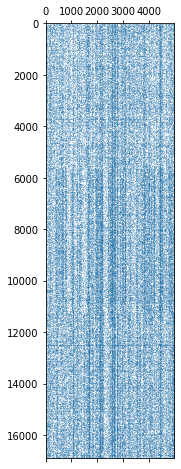

In [0]:
# to visualize the sparsity 
plt.figure(figsize=(10,8))
plt.spy(train_TFIDF,markersize=0.05)

In [0]:
train_label = np.zeros((16905,3))

In [0]:
for count,i in enumerate(train_resampled['author.1']):
  train_label[count,i] = 1

In [0]:
train_label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [0]:
X_train, X_val, y_train, y_val = train_test_split( train_TFIDF, train_label, test_size=0.1, random_state=42)

In [0]:
from sklearn.linear_model import Ridge
regrtest = Ridge()

## 2.2 parameter search

We wil take the TFIDF weight matrix (5000 dimensions) to train the multi-class classification regression.

The hyper-parameter to adjust is the alpha, which is the regularization strength of the model.

The objective function is shown here:

$ ||y - Xw||^2_2 + alpha * ||w||^2_2 $

In [0]:
regrtest.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
predict_ridge = regrtest.predict(X_train)

In [0]:
def accuracy_report(pred,target):
  pred = np.argmax(pred,axis=1)
  target = np.argmax(target,axis=1)
  return np.sum(np.where(pred == target,1,0))/len(target)

In [0]:
accuracy_report(predict_ridge,y_train)

0.9152754042329433

In [0]:
predict_ridge2 = regrtest.predict(X_val)

In [0]:
accuracy_report(predict_ridge2,y_val)

0.7930218805440568

In [0]:
list_alpha = [i for i in range(20)]
list_accuracy = []

In [0]:
for i in list_alpha:
  regrtest = Ridge(alpha=i)
  regrtest.fit(X_train,y_train)
  predict_ridge2 = regrtest.predict(X_val)
  list_accuracy.append(accuracy_report(predict_ridge2,y_val))

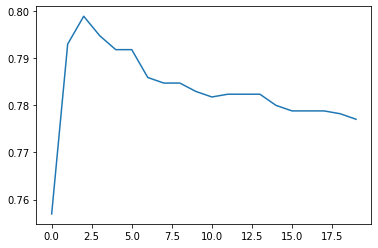

In [0]:
plt.plot(list_alpha,list_accuracy)

## 2.3 final model and explanation

We'll use alpha = 2 to train the model.

In [0]:
regrtest = Ridge(alpha=2)

In [0]:
regrtest.fit(X_train,y_train)

Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [0]:
predict_ridge = regrtest.predict(X_train)
accuracy_report(predict_ridge,y_train)

0.9016037859865913

In [0]:
predict_ridge = regrtest.predict(X_val)
accuracy_report(predict_ridge,y_val)

0.7995269071555293

## 2.4 feature importance

The TFIDF accuracy is about 80% so that is a pretty good start. Now as promised we can take a look at what words contribute most. 

In [0]:
dict_author = {1:'HP Lovecraft',2:'Mary Shelley',0:'Edgar Allen Poe'}
for author in range(3):
  print('author = {}'.format(dict_author[author]))
  print('----------')
  print('top 5 most unlikely words')
  for i in list(np.argsort(regrtest.coef_[author])[:5]):
    print('{}'.format(tfidf1.get_feature_names()[i]),'  {:.3f}'.format(regrtest.coef_[author,i]))
  print(' ')
  print('top 5 most likely words')
  for j in list(np.argsort(regrtest.coef_[author])[4995:]):
    print('{}'.format(tfidf1.get_feature_names()[j]),'  {:.3f}'.format(regrtest.coef_[author,j]))
  print('----------')

author = Edgar Allen Poe
----------
top 5 most unlikely words
raymond   -0.681
despit   -0.565
shew   -0.542
west   -0.536
endeavour   -0.535
 
top 5 most likely words
drawer   0.667
however   0.671
minutes   0.687
ordinari   0.769
dupin   0.773
----------
author = HP Lovecraft
----------
top 5 most unlikely words
and   -0.511
portion   -0.489
sun   -0.487
heart   -0.449
which   -0.435
 
top 5 most likely words
birch   0.771
gilman   0.795
despit   0.883
west   0.918
later   0.958
----------
author = Mary Shelley
----------
top 5 most unlikely words
later   -0.511
however   -0.481
posit   -0.442
thing   -0.426
german   -0.410
 
top 5 most likely words
her   0.720
adrian   0.720
perdita   0.749
endeavour   0.796
raymond   1.046
----------


It turns out that a lot of these are names of characters. So they are pretty specific to the novel. For example, Dupin is a character in "The Murders in the Rue Morgue" by Peo. This name has highest regression coefficient meaning associated for Poe.

Similarly, Gilman is a character in Lovecraft "The Dreams in the Witch-House".

Adrian and Perdita are characters from Mary Shelley's novel "The Last Man".

# 3. Naive-Bayes Classification

Another ML approach we will look at is Naive Bayes classifier. Given a word vector 
$x_1,...,x_n$ representing a sentence. The value of the vector can be frequency of words in the document belonging to a class or a binary values of whether the word is presence or absence in the document. We can ask what is the conditional probability that this vector belong to a class $C_k$, i.e.

$p(C_k | x_1,...,x_n)$

The Bayes' theorem states that 

$p(C_k | x) = \frac{p(C_k)p(x|C_k)}{p(x)}$

And we can write 

$P(C_k,x_1,...,x_n) = p(x_1|x_2,...,x_n,C_k)p(x_2|x_3,...,x_n,C_k)...p(x_{n-1}|x_n,C_k)p(x_{n}|C_k)p(C_k)$

The problem is that some pairs of $x_i$ are not independent. Certain words tend to go together, and certain words are not likely to go together. So that makes the actual Bayes' theorem calculation will have more terms representing the probability of one word depending on another. This is the part that is difficult to calculate.

Now the reason Naive Bayes is "naive" is because make an assumption to simplify this problem. The assumption is independence among features. That is to say,

$P(x_1,x_2) = P(x_1)P(x_2)$

So the model above is simplified to 

$p(C_k|x_1,...,x_n) = p(C_k)p(x_1|C_k)p(x_2|C_k)p(x_3|C_k)...$

$ = p(C_k)\prod_{i=1}^np(x_i|C_k)$

So with this assumption, even though it is unlikely to be corect, but it will work pretty well in practice. And now we should have everything we need to do the work pretty easily.

One more thing to think about is how to model a probability distribution of words in classes, i.e. whether 
$p(x_n|C_k)$ is normally distributed or distributed according to Bernoullidistribution, etc.

In our case, we will look at Bernoulli Naive Bayes since word occurances are binary, i.e. either presence or absence. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

## 3.1 Bernoulli Naive Bayes

In [0]:
count_vector1 = CountVectorizer(max_features=5000,binary=True)

In [0]:
train_count = count_vector1.fit_transform(train_resampled['stemmed_text'])

In [39]:
train_count

<16905x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 171345 stored elements in Compressed Sparse Row format>

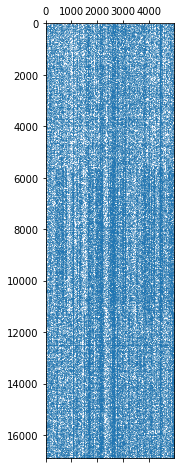

In [40]:
# to visualize the sparsity 
plt.figure(figsize=(10,8))
plt.spy(train_count,markersize=0.09)

In [0]:
train_label = list(train_resampled['author.1'].values)

In [0]:
X_train, X_val, y_train, y_val = train_test_split( train_count.toarray(), train_label, test_size=0.1, random_state=42)

In [0]:
from sklearn.naive_bayes import BernoulliNB
gnb = BernoulliNB()
y_pred = gnb.fit(X_train, y_train).predict(X_val)

In [45]:
print('overall accuracy')
print(np.sum(y_pred == y_val)/len(y_pred))

overall accuracy
0.7983441750443524


In [0]:
from sklearn.metrics import confusion_matrix
array_confusion = confusion_matrix(y_val,y_pred,normalize='true')

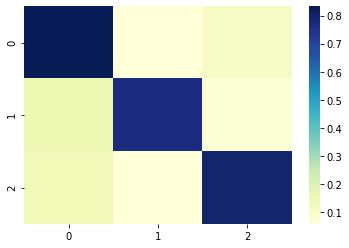

In [49]:
sns.heatmap(array_confusion, cmap="YlGnBu")

## 3.2 Multinomial Naive Bayes

The Bernoulli Naive Bayes only look at binary count, i.e. presence or absence. If we want to a word distribution model that takes into account th number of counts, we need another probability distribution. In this case, we will use Multinomial distribution. So the model is Multinomial Naive Bayes. 

In [0]:
count_vector1 = CountVectorizer(max_features=5000)

In [0]:
train_count = count_vector1.fit_transform(train_resampled['stemmed_text'])

In [0]:
X_train, X_val, y_train, y_val = train_test_split( train_count.toarray(), train_label, test_size=0.1, random_state=42)

In [0]:
from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()
y_pred = gnb.fit(X_train, y_train).predict(X_val)

In [0]:
print('overall accuracy')
print(np.sum(y_pred == y_val)/len(y_pred))

overall accuracy
0.8036664695446482


In [0]:
from sklearn.metrics import confusion_matrix
array_confusion = confusion_matrix(y_val,y_pred,normalize='true')

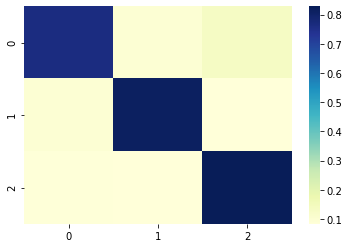

In [0]:
sns.heatmap(array_confusion, cmap="YlGnBu")

# 4 recurrent neural network

The models we have so far only look at the word level information. And even though they are performing pretty well, one might want to look at higher level information, such as phrases or sentences. So we need a model that perserves the word order somehow.

First we will use a recurrent neural network to model the sequences of words in sentences and finally classify them to one of 3 authors.

The diagram for recurrent neural net is shown below.

![alt text](http://www.easy-tensorflow.com/images/NN/06.png)

Look at the unfolded diagram of the network. Our strategy is to feed words (in the form of numerical tokens), one token as a time to the model. these tokens is embedded in the form a vector. The model receives input from this embedded vector and a hidden state from previous token (for first token, the hidden state is generated and feed into the model directly). The hidden state carries information from previous words in the sequence to the next word. Until it reaches the last token. The hidden state on the last token is then sent to a fully connected classification layer that classify to the author label.

Now, one problem that we will encounter is that if our text is long, by the time we train the model to end, the information from the beginning of the text is lost. The hidden states that is carried from the beginning get changed successively too many times, such that the back-propagated gradients can vanish.


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Gated_Recurrent_Unit.svg/1920px-Gated_Recurrent_Unit.svg.png)

To ameliorate this delay problem, we will be using gated recurrent units (GRU) as a neuron in the recurrent network. Roughly speaking, this kind of unit provides a gaing mechanism that control the flow of information. This full understanding of the math is quite complicated and won't be pursued here. 

## 4.1 Packages and libraries

In [0]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import timeit
import torch.nn.functional as F

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0)) #hopefully we get Tesla P100 

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 4.2 tokenization

We will implement our own tokenization steps here.

In [0]:
train_resampled = train_resampled[['author','text']]

In [0]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]

In [0]:
def tokenize_frame(frame1):
    frame = frame1.copy(deep=True)
    frame['tokens'] = frame['text'].apply(lambda x: word_tokenize(x))
    return frame

In [0]:
train_resampled = tokenize_frame(train_resampled)

In [0]:
train_resampled['tokens'] = train_resampled['tokens'].apply(lambda x: [y for y in x if y not in punc])

In [0]:
list_vocab = []
for sentence in train_resampled['tokens']:
  for word in np.unique(sentence):
    list_vocab.append(word)
list_vocab = np.unique(list_vocab)

We will create a dictionary mapping between word token and numerical token. 
The goal is to create a tensor of numeric tokens of the same lengths. Therefore, if text are longer than the allowed length, we will trim off the extra words. And if the text are shorter than the prescribed length, we will pad the tensor with [0].

Note that the padding is on the left side, because the sequence goes from left to right. You want the last tokens in the sequence to be your words, so the hidden states contain the information about those words. If we padd the right side, the information (carried in the hidden state till the fully connected layer in the end) can get lost when encountering a long sequences of padding. 

In [0]:
len(list_vocab)

26077

In [0]:
def create_vocab_dict(vocab):
    dict_str2int = {}
    dict_int2str = {}
    for i,j in enumerate(vocab,1):
        dict_str2int[j] = int(i)
        dict_int2str[i] = j
    return dict_str2int, dict_int2str

In [0]:
dict_str2int, dict_int2str = create_vocab_dict(list_vocab)

In [0]:
def apply_dict(list1):
    result = []
    try:
      for i in list1:
        result.append(dict_str2int[i])
    except:
      for i in list1:
        if i not in dict_str2int.keys():
          print(i,' not in dict')
          dict_str2int[i] = len(dict_str2int.keys())
          result.append(dict_str2int[i])
        else:
          result.append(dict_str2int[i])
    return result

In [0]:
def word2token(frame1):
    frame = frame1.copy(deep=True)
    frame['numeric_tokens'] = frame['tokens'].apply(lambda x: apply_dict(x))
    return frame

In [0]:
train_resampled = word2token(train_resampled)

In [0]:
list_len = []
for i in train_resampled['numeric_tokens']:
  list_len.append(len(i))

In [0]:
np.quantile(list_len, 0.99)  # most text is shorter than 85 tokens.

85.0

In [0]:
def pad_truncate_array(frame,max_len=160,truncate='Post'):
    result = []
    for item in frame['numeric_tokens']:
        if len(item) > max_len:
            if truncate == 'Post':
                result.append(item[:max_len])
            else:
                result.append(item[len(item) - max_len:])
        else:
            result.append([0]*(max_len - len(item)) + item)
    return np.array(result)

In [0]:
train_array = pad_truncate_array(train_resampled,max_len = 100)

In [0]:
train_array

array([[    0,     0,     0, ...,  7200, 17247,  5430],
       [    0,     0,     0, ..., 25862,  4810,  2999],
       [    0,     0,     0, ..., 14317, 21911,  7358],
       ...,
       [    0,     0,     0, ..., 23509, 17494, 16103],
       [    0,     0,     0, ..., 26005, 17459,  5246],
       [    0,     0,     0, ..., 17459, 24649, 17859]])

In [0]:
X_train, X_val, y_train, y_val = train_test_split( train_array, train_resampled['author'], 
                                                  test_size=0.1, random_state=42)

In [0]:
batch_size = 96
train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.long), torch.tensor(y_train,dtype=torch.long))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [0]:
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.long), torch.tensor(y_val,dtype=torch.long))
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [0]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([96, 100])
Sample input: 
 tensor([[    0,     0,     0,  ..., 25573,  6578, 12445],
        [    0,     0,     0,  ...,  5620, 16746, 13111],
        [    0,     0,     0,  ..., 17459, 23509, 13914],
        ...,
        [    0,     0,     0,  ..., 26030, 20989, 13749],
        [    0,     0,     0,  ..., 23768, 11114, 23519],
        [    0,     0,     0,  ...,  5513, 13768, 22075]])

Sample label size:  torch.Size([96])
Sample label: 
 tensor([1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1,
        2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0,
        0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1,
        1, 0, 2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 1])


A nice thing about Pytorch is that, unlike in Keras, in pytorch you get to see the inside of the model and how it trains. This helps with learning about the how the model works.

We will define a recurrent net with has word embedding layer, number of GRU units, size of hidden dimensions, and size of output layer.

## 4.3 Model building and training

In [0]:
class GRUNet(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, output_dim, n_layers =1, drop_prob=0.3):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.sig = nn.Softmax()
        
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        out, hidden = self.gru(embeds, hidden)
        out = self.fc(out[:,-1])
        out = self.sig(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

We will send the model to GPU. GPU will help shorten the training time tremendously.

In [0]:
vocab_size = len(list_vocab) + 1 #len(dict_str2int + 1 (for padding token = [0]))
output_size = 3
embedding_dim = 300 
hidden_dim = 400
n_layers = 2
drop_prob = 0.5

net = GRUNet(vocab_size,embedding_dim, hidden_dim,output_size, n_layers,drop_prob)

net = net.to(device)

GRUNet(
  (embedding): Embedding(26078, 300)
  (gru): GRU(300, 400, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=400, out_features=3, bias=True)
  (sig): Softmax(dim=None)
)

After defining the model, we now will define the optimizer and loss. 

In [0]:
learning_rate = 0.00001
weight_decay = 0.001
criterion = nn.CrossEntropyLoss() #nn.NLLLoss()
#criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight_decay)
net

GRUNet(
  (embedding): Embedding(26078, 300)
  (gru): GRU(300, 400, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=400, out_features=3, bias=True)
  (sig): Softmax(dim=None)
)

In [0]:
def measure_accu(torch_output,torch_label):
  pred_array = torch.argmax(torch_output,axis=1).detach().cpu().numpy()
  correct_array = torch_label.view(-1).cpu().numpy()
  correct = np.where(pred_array == correct_array,1,0)
  #print(correct)
  return np.sum(correct)/len(correct)

In [0]:
iter_val_loss = []
iter_train_loss = []
epoch_train_accu = []
epoch_val_accu = []

We will train the model for 20 epochs. Note that we need to do gradient clipping every iteration. The idea is to re-scale the gradient to prevent it from getting too large.

This is to prevent gradient exploding problem. 

In [0]:
epochs = 20
clip = 3
print_every = 159 # = len(train_loader)
count = 0


net.train()
for ite in range(epochs):
    print('start epoch ')
    start = timeit.default_timer()
    temp_accu = []
    for inputs, labels in train_loader:

        count += 1
        batch_size = inputs.shape[0]
        inputs, labels = inputs.to(device), labels.to(device)
        h = net.init_hidden(batch_size) #.to(device)
        net.zero_grad()
        
        output,h = net(inputs,h)
        temp_accu.append(measure_accu(output,labels))
        loss = criterion(output, labels)
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(),clip)
        optimizer.step()
        
        iter_train_loss.append(loss.item())

        if count % print_every == 0:

            val_losses = []
            val_accu = []
            net.eval()
            for inputs_val, labels_val in val_loader:
                batch_size = inputs_val.shape[0]
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                val_h = net.init_hidden(batch_size) #.to(device)
                
                output_val, val_h = net(inputs_val,val_h)
                
                val_loss = criterion(output_val, labels_val)
                
                val_losses.append(val_loss.item())
                val_accu.append(measure_accu(output_val,labels_val))
                iter_val_loss.append(val_loss.item())
            
            epoch_val_accu.append(np.mean(val_accu))
            stop = timeit.default_timer()
            
            net.train()
            print('Epoch: {}/{}...'.format(ite + 1,epochs),
                 'step: {}...'.format(count),
                 'loss: {:.6f}...'.format(loss.item()),
                 'val loss: {:.6f}'.format(np.mean(val_losses)))
            del inputs,labels
    epoch_train_accu.append(np.mean(temp_accu))
    stop = timeit.default_timer()
    print('one epoch takes {:.3f}'.format(stop - start))

start epoch 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20... step: 159... loss: 0.639097... val loss: 0.797074
one epoch takes 5.536
start epoch 
Epoch: 2/20... step: 318... loss: 0.603204... val loss: 0.802459
one epoch takes 5.520
start epoch 
Epoch: 3/20... step: 477... loss: 0.662570... val loss: 0.798582
one epoch takes 5.537
start epoch 
Epoch: 4/20... step: 636... loss: 0.618116... val loss: 0.799298
one epoch takes 5.486
start epoch 
Epoch: 5/20... step: 795... loss: 0.601601... val loss: 0.798625
one epoch takes 5.512
start epoch 
Epoch: 6/20... step: 954... loss: 0.643404... val loss: 0.803875
one epoch takes 5.524
start epoch 
Epoch: 7/20... step: 1113... loss: 0.599640... val loss: 0.802888
one epoch takes 5.525
start epoch 
Epoch: 8/20... step: 1272... loss: 0.599972... val loss: 0.798667
one epoch takes 5.544
start epoch 
Epoch: 9/20... step: 1431... loss: 0.633334... val loss: 0.804388
one epoch takes 5.534
start epoch 
Epoch: 10/20... step: 1590... loss: 0.642718... val loss: 0.799941
one epoch takes 5.545
start ep

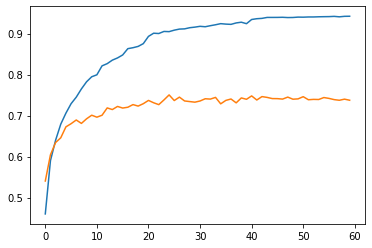

In [0]:
plt.plot(epoch_train_accu)
plt.plot(epoch_val_accu)

In [0]:
np.max(epoch_val_accu)

0.7504119585687383

So it seems that the recurrent neural net is decent but certainly not as good as the first two ML models. We do see overfitting in the training set, while the validation stays at about 0.75 accuracy.

Again, the problem that we might be seeing here is the long dependency problem. 

# 5. BERT classification

Now finally we get to the last approach which is BERT (Bidirectional Encoder Representations from Transformers). I have written [here](https://github.com/VincentK1991/BERT_summarization_1) as a primer for BERT, so go check that out. In the previous repository, that is just using pre-trained BERT to do the embedding. In this case, we will fine-tune BERT for classification.

The advantage of BERT over other models are several. First, BERT looks at sequence information and sentence level information. This is the advantage over TFIDF or Naive-Bayes. Second, BERT is pre-trained, so this is already a big advantage over the recurrent neural net that we made previously. Third is that BERT is bi-directional, meaning the flow of information can be from later sequence to the fron of sequence, unlike the recurrent neural network where information flow only from left to right. 
And finally, to solve the long-term dependency that is so problematic in the recurrent neural net, BERT has an attention mechanism that weight the importance of particular words to other surrounding words.


What we need to do here for fine-tuning is to plug in the final layer, a fully-connected classification layer with the correct output size. This step is even simplified when we use the Hugging Face transformers package. We can simply import "BertForSequenceClassification", and the fully-connected layer is already there. We just specify the output size.

The training strategy is also very simple. Just calculate the loss and do back-propagation.

## 5.1 Packages and Libraries

In [7]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

nltk.download('punkt')
from nltk import sent_tokenize
%tensorflow_version 1.x
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
TensorFlow 1.x selected.


Using TensorFlow backend.


In [8]:
!pip install transformers

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 3.7MB 14.3MB/s 
     |████████████████████████████████| 890kB 33.2MB/s 
     |████████████████████████████████| 1.0MB 37.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=711e8a7ce364055ad142e5657dc31b8fe97042ff72feadacf6fe8792db982a74
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


Instead of making a new tokenizer ourselves,We will use BERTtokenizer so we don't need to train BERT from the beginning.

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [51]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0)) #hopefully we get Tesla P100 

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 5.2 Tokenization

This step is for making numeric tokens, with padding and truncating. Also we need the special tokens [CLS] and [SEP] for marking the start and end of a text. We will also have an attention mask which tells the BERT model to ignore the padding [0].

In [0]:
def split_tokenize_formatting(paragraph,max_len=100):

  input_tokens = []
  for i in paragraph:
    input_tokens.append(tokenizer.encode(i, add_special_tokens=True))
  # temp = []
  # for i in input_tokens:
  #   temp.append(len(i))
  # if np.max(temp) > max_len:
  #   print('sentence longer than the max_len')
  # if np.max(temp) > 512:
  #   print('warning: sentence longer than 512')
  #   print('suggest to change max_len to 512, the remainder will be truncated')
  input_ids = pad_sequences(input_tokens, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")

  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]  # create a list of 0 and 1.
    attention_masks.append(att_mask)  # basically attention_masks is a list of list

  input_ids = torch.tensor(input_ids)  
  attention_mask = torch.tensor(attention_masks)

  return input_ids, attention_mask

In [0]:
list_comment = list(train_resampled['text'].values)

In [12]:
input_ids, attention_mask = split_tokenize_formatting(list_comment,100)

Token indices sequence length is longer than the specified maximum sequence length for this model (953 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors


In [0]:
all_label = torch.tensor(train_resampled['author.1'].values)

In [0]:
input_train, input_val, label_train, label_val = train_test_split(input_ids, all_label, 
                                                                  test_size=0.1, random_state=42)
mask_train, mask_val, label_train, label_val = train_test_split(attention_mask, all_label, 
                                                                  test_size=0.1, random_state=42)

In [0]:
batch_size = 100

train_data = TensorDataset(input_train, mask_train, label_train)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(input_val, mask_val, label_val)
validation_sampler = SequentialSampler(validation_data)
val_loader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## 5.3 Model building and training

Note here that the version of BERT we'll use is 
**bert-base-uncased**. 

This model only contain lower-case characters. It has 12 layers, 768 hidden dimensions, and 110M parameters.




In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,  
    output_attentions = False,
    output_hidden_states = False)
#model.to(device)

In [0]:
from transformers import get_linear_schedule_with_warmup

### 5.3.1 objected-oriented class to help with training

This code is just for keeping track of the parameters we will use for training the model. 

This will take quite a bit of time even with GPU, each epoch will take a couple of minutes to complete.

In [0]:
class train_BERT(object):
    def __init__(self,input_model,device,batch_train_dataXY,batch_val_dataXY,
                 batch_test_dataXY=None,num_class=10,learning_rate=0.001,L2=0):
        super(train_BERT,self).__init__()
        
        self.model = input_model #().apply(weights_init)
        #self.model.apply(weights_init)
        self.model.to(device)
        self.train_loader = batch_train_dataXY
        self.test_loader = batch_test_dataXY
        self.val_loader = batch_val_dataXY
        self.learning_rate = learning_rate
        self.L2 = L2
        self.optim = AdamW(self.model.parameters(), lr=self.learning_rate,eps=1e-08, weight_decay=self.L2)
        # self.scheduler = get_linear_schedule_with_warmup(self.optim, 
        #                   num_warmup_steps = 0, # Default value in run_glue.py
        #                   num_training_steps = train)

        #self.criterion = nn.CrossEntropyLoss()
        self.loss_train_list = []
        self.loss_val_list = []
        self.train_accu_list = []
        self.val_accu_list = []
        self.test_accu_list = []
        self.total_epoch = 0
    
    def train(self,epochs,learning_rate=None,L2=None,eval_every=2,print_every=2):
        if type(learning_rate) == float:
          self.learning_rate = learning_rate

        if type(L2) == float:
          self.L2 = L2
        self.set_new_rate()
        scheduler = get_linear_schedule_with_warmup(self.optim, 
                    num_warmup_steps = 0, # Default value in run_glue.py
                    num_training_steps = len(self.train_loader)*epochs)
        for index_epoch in range(epochs):
            temp_list = []
            self.model.train()
            for step, batch in enumerate(self.train_loader):

                batch = tuple(t.to(device) for t in batch)
                input_sent, input_masks, input_label = batch

                self.optim.zero_grad()
                outputs = self.model(input_sent, token_type_ids=None, 
                                    attention_mask=input_masks, labels=input_label)
                loss = outputs[0]
                temp_list.append(loss.item())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optim.step()
                scheduler.step()
                del input_sent, input_masks, input_label, loss, outputs

            self.loss_train_list.append(np.mean(temp_list))

            if index_epoch > 0 and index_epoch % eval_every == 0:
                self.model.eval()
                temp_list = []
                for batch in self.val_loader:
                  batch = tuple(t.to(device) for t in batch)
                  input_sent, input_masks, input_label = batch
                  outputs = self.model(input_sent, token_type_ids=None, 
                                        attention_mask=input_masks, labels=input_label)
                  
                  loss = outputs[0]
                  temp_list.append(loss.item())
                  del input_sent, input_masks, input_label, loss, outputs

            self.loss_val_list.append(np.mean(temp_list))
        
            train_accu= self.test_model(which_model='train')
            val_accu = self.test_model(which_model='validation')
            self.train_accu_list.append(train_accu)
            self.val_accu_list.append(val_accu)
            self.total_epoch += 1
            if index_epoch % print_every == 0:
                print('total epoch = ',self.total_epoch, ' train accuracy= ', self.train_accu_list[-1],'; val accuracy = ', 
                      self.val_accu_list[-1])
    

    def test_model(self,which_model='test'):
        self.model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
        
        if which_model == 'train':
          loader = self.train_loader
        elif which_model == 'validation':
          loader = self.val_loader
        elif which_model == 'test':
          loader = self.test_loader

        with torch.no_grad():
            num_correct = 0

            for batch in loader:
                batch = tuple(t.to(device) for t in batch)
                input_sent, input_masks, input_label = batch

                outputs = self.model(input_sent, token_type_ids=None, 
                                     attention_mask=input_masks, labels=input_label)
                num_correct += self.count_accuracy(outputs[1],input_label)
                del input_sent, input_masks, input_label,outputs
        return (num_correct / len(loader))

    def count_accuracy(self,preds,target):
      preds = preds.detach().cpu().numpy()
      target = target.cpu().numpy()
      pred_flat = np.argmax(preds, axis=1).flatten()
      labels_flat = target.flatten()
      return np.sum(pred_flat == labels_flat)

    def get_train_loss(self):
        return self.loss_train_list
    def get_val_loss(self):
        return self.loss_val_list
    def get_train_accu(self):
        return self.train_accu_list
    def get_test_accu(self):
        return self.test_accu_list
    def get_val_accu(self):
        return self.val_accu_list
    def get_params(self):
        print(self.model)
    def get_rate(self):
        return self.learning_rate, self.L2
    def get_model(self):
        return self.model
    def set_new_rate(self):
      self.optim = AdamW(self.model.parameters(), lr=self.learning_rate,weight_decay=self.L2)

In [0]:
trial1 = train_BERT(model,device,train_loader,val_loader,None,3,1e-5,1e-8)

In [22]:
trial1.train(5,eval_every=1,print_every=1)

total epoch =  1  train accuracy=  79.57516339869281 ; val accuracy =  77.47058823529412
total epoch =  2  train accuracy=  85.56862745098039 ; val accuracy =  82.17647058823529
total epoch =  3  train accuracy=  89.30065359477125 ; val accuracy =  84.17647058823529
total epoch =  4  train accuracy=  91.359477124183 ; val accuracy =  84.6470588235294
total epoch =  5  train accuracy=  91.91503267973856 ; val accuracy =  84.94117647058823


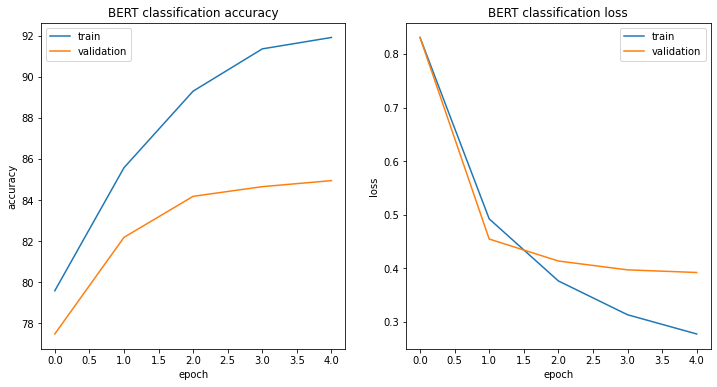

In [32]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(trial1.get_train_accu(),label='train')
ax[0].plot(trial1.get_val_accu(),label='validation')
ax[0].set_title('BERT classification accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()
ax[1].plot(trial1.get_train_loss(),label='train')
ax[1].plot(trial1.get_val_loss(),label='validation')
ax[1].set_title('BERT classification loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

Result

The validation accuracy is about 0.85. And it might get slightly better if one plays around with hyper-parameters, or simply train longer.  

The result is much better than the recurrent neural net, but only marginally better than the Naive Bayes. The disadvantage of BERT is that, even with GPU, it still takes a long time to train.

# 6. Citation

[Naive Bayes](https://www.geeksforgeeks.org/naive-bayes-classifiers/)
Basic article on Naive Bayes

[GRU and LSTM blog](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
nice illustration on how LSTM and GRU works. 

[overview of BERT fine-tuning](http://jalammar.github.io/illustrated-bert/)
illustrated overview of language model fine-tuning, BERT, OpenAI GPT-2, ELMo. 

[BERT fine-tuning with codes](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) Nice blogpost on BERT sequence classification. Very easy to read, has codes to follow, and has a lot of illustrations.

[explaining Attention](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) This blog post does a pretty good job explaining various forms of attention mechanisms used in machine learning.

[BERT's attention](https://www-nlp.stanford.edu/pubs/clark2019what.pdf)
A paper analyzing how BERT's attention works.  